In [4]:
import imageio
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

In [26]:
(train_img, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [28]:
train_img = train_img[:,:,:,None].astype('float32')   # adding channel
train_img = (train_img - 127.5 )/127.5    # Normalize values to [-1,1]

In [34]:
Buffer_size = 60000   # used to shuffle the data
Batch_size = 256
 

In [35]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_img).shuffle(Buffer_size).batch(Batch_size)

In [36]:
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


## Create Model

### 1. Generator

In [88]:
def generator():
    model = tf.keras.Sequential()  # input is Gaussian noise of size 100 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # observed that GAN converges fast when there is no bias
    model.add(layers.BatchNormalization())  # active during training only
    model.add(layers.LeakyReLU())  # good with gradients 

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)  # here None refers to batch size

    model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5), strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5), strides=(2,2),padding='same',use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
    
    
    

In [89]:
def generator2():
    model = tf.keras.Sequential()  # input is Gaussian noise of size 28,28,1 
    model.add(layers.Conv2D(1,(2,2), padding='same', use_bias=False, input_shape=(28,28,1,))) # observed that GAN converges fast when there is no bias
    model.add(layers.BatchNormalization())  # active during training only
    model.add(layers.LeakyReLU())  # good with gradients 

    model.add(layers.Conv2D(64,(5,5), strides=(1,1) ,padding='same',use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(16, (5,5), strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 28, 28, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (5,5), strides=(1,1),padding='same',use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
    
    
    

In [90]:
# # generator = generator()

# noise = tf.random.normal([1,100])
# img = generator(noise, training=False)
# print(img.shape)
# plt.imshow(img[0,:,:,0],cmap='grey')

In [91]:
# Generator2 = generator2()

# noise = tf.random.normal([1,28,28,1])
# img = Generator2(noise, training=False)
# print(img.shape)
# plt.imshow(img[0,:,:,0],cmap='grey')

### 2. Discriminator

In [92]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(16))
    model.add(layers.Dense(1))  # logits (output without sigmoid or before sigmoid)
    # model.add(layers.Dense(1,activation='sigmoid'))

    return model


In [93]:
# D = discriminator()
# out = D(img)
# print(out)

In [94]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Here the discriminator should be able to classify real as real image and fake as fake image.

In [95]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)

    return real_loss+fake_loss

Here the generator should try to generate fake image such that the disciminator classifies it as real image, so the loss fro generator is cross_entropy(1,fake) as

In [96]:
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

In [117]:
G_opt = tf.keras.optimizers.Adam(1e-4)
D_opt = tf.keras.optimizers.Adam(1e-4)

In [118]:
G = generator()
D = discriminator()

Saving checkpoints

In [119]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=G_opt,
    discriminator_optimizer=D_opt,
    generator=G,
    discriminator=D
)

 ### Training

In [121]:
@tf.function

def train_step(img):
    noise = tf.random.normal([Batch_size,noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_img = G(noise,training=True)

        real_out = D(img, training=True)
        fake_out = D(fake_img, training=True)

        G_loss = generator_loss(fake_out)
        D_loss = discriminator_loss(real_out, fake_out)

    grad_G = gen_tape.gradient(G_loss, G.trainable_variables)
    grad_D = disc_tape.gradient(D_loss, D.trainable_variables)

    G_opt.apply_gradients(zip(grad_G, G.trainable_variables))
    D_opt.apply_gradients(zip(grad_D, D.trainable_variables))
    
    

In [122]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        # See the progress of the model as it trains in the form of generated images
        display.clear_output(wait=True)
        generate_and_save_images(G,epoch+1,seed)

        # Save the model every 10 epochs
        if(epoch+1)%10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(G,epochs,seed)
        

In [125]:
def generate_and_save_images(model, epoch, test_input):

    pred = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(pred.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(pred[i,:,:,0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('epoch_{:0d}.png'.format(epoch))
    plt.show()
        

In [120]:
epochs = 50
noise_dim = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dim])

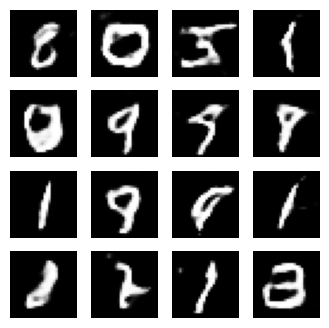

In [127]:
train(train_dataset, 20)